In [1]:
import os, struct
import matplotlib as plt
from array import array as pyarray
import pandas as pd
from openpyxl import load_workbook
from pylab import *
import numpy as np

In [2]:
def load_NMNIST(dataset="training", digits=range(10), path=r'E:\Users\Shashi\OneDrive\Datasets\Shapes'):
    
    if dataset == "training":
        fname_img = os.path.join(path, 'Shapes_1_1_Train_Features.dat')
        fname_lbl = os.path.join(path, 'Shapes_1_1_Train_Labels.dat')
    elif dataset == "testing":
        fname_img = os.path.join(path, 'Shapes_1_1_Test_Features.dat')
        fname_lbl = os.path.join(path, 'Shapes_1_1_Test_Labels.dat')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    lbl = np.fromfile(flbl, dtype=np.uint8)
    flbl.close()

    fimg = open(fname_img, 'rb')
    img = np.fromfile(fimg, dtype=np.uint8)
    fimg.close()

    size=len(lbl)

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    rows=28;cols=28;

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    return images, labels

In [3]:
def vectortoimg(v,show=True):
    plt.imshow(v.reshape(28, 28),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

In [4]:
import keras

Using TensorFlow backend.


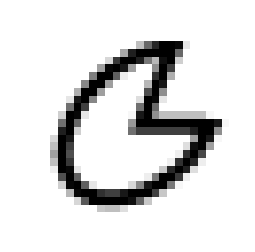

In [5]:
path= os.path.join(os.path.curdir, 'data')
images, labels = load_NMNIST('training', digits=[0,1,2], path=path)

flatimages = list()
for i in images:
    flatimages.append(i.ravel())
x_train = asarray(flatimages) # X now contains 60000 feature vectors, each of dimension 784
y_train=labels # T contains class labels with 0->Triangle, 1->Square, 2->Pizza
vectortoimg(x_train[1])

print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure(figsize=(10,10))
nrows=15
ncols=15
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(x_train[np.random.randint(len(y_train))],show=False)
plt.show()

In [7]:
images.shape

(60000, 28, 28)

In [8]:
labels.shape

(60000, 1)

In [9]:
images, labels = load_NMNIST('testing', digits=[0,1,2], path=path)
flatimages = list()
for i in images:
    flatimages.append(i.ravel())
x_test = asarray(flatimages) # X now contains 60000 feature vectors, each of dimension 784
y_test = labels # T contains class labels with 0->Triangle, 1->Square, 2->Pizza

In [10]:
from keras.layers import Input, Dense
from keras.models import Model

## single fully-connected neural layer as encoder and as decoder

In [81]:
# this is the size of our encoded representations
encoding_dim = 32  # 3 floats -> 3 floats represents 3 classes

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## Let's also create a separate encoder model

In [82]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## decoder model

In [83]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Use Crossentropy loss, and Adadelta Optimizer

In [84]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [85]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Train

In [86]:
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 2s - loss: 0.6655 - val_loss: 0.6215
Epoch 2/25
60000/60000 [==============================] - 2s - loss: 0.3876 - val_loss: 0.1143
Epoch 3/25
60000/60000 [==============================] - 3s - loss: 0.0504 - val_loss: 0.0225
Epoch 4/25
60000/60000 [==============================] - 2s - loss: 0.0151 - val_loss: 0.0103
Epoch 5/25
60000/60000 [==============================] - 3s - loss: 0.0080 - val_loss: 0.0063
Epoch 6/25
60000/60000 [==============================] - 3s - loss: 0.0052 - val_loss: 0.0043
Epoch 7/25
60000/60000 [==============================] - 3s - loss: 0.0037 - val_loss: 0.0032
Epoch 8/25
60000/60000 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0025
Epoch 9/25
60000/60000 [==============================] - 4s - loss: 0.0022 - val_loss: 0.0020-
Epoch 10/25
60000/60000 [==============================] - 4s - loss: 0.0018 - val_loss: 0.001

In [87]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

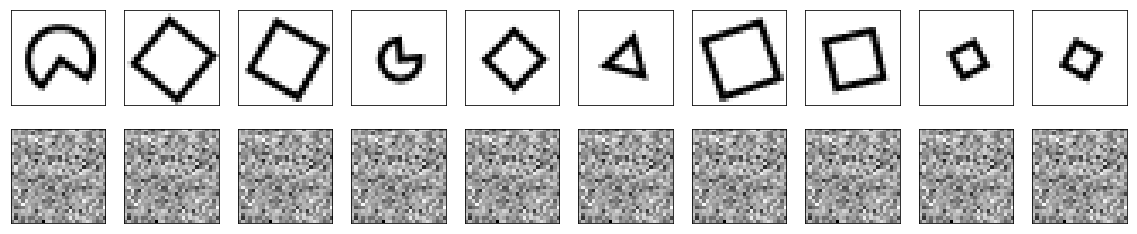

In [89]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [73]:
encoded_imgs.shape

(10000, 1)

In [74]:
result = np.zeros((len(y_test), 2))
for index, item in enumerate(y_test):
    result[index] = (y_test[index], np.max(encoded_imgs[index]))

In [75]:
result[0]

array([ 2.,  0.])

In [76]:
df = pd.DataFrame(result)

In [77]:
df.rename(columns={0: 'target', 1: 'y_predict'}, inplace=True)

In [78]:
df.groupby(df.target).describe()

y_predict                                   
           count mean  std  min  25%  50%  75%  max
target                                             
0.0       3390.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1.0       3293.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2.0       3317.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [79]:
df.groupby(df.y_predict).describe()

target                                           
             count    mean       std  min  25%  50%  75%  max
y_predict                                                    
0.0        10000.0  0.9927  0.818971  0.0  0.0  1.0  2.0  2.0

In [90]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [91]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 5s - loss: 1.6842e-04 - val_loss: 1.7318e-04
Epoch 2/25
60000/60000 [==============================] - 4s - loss: 1.6799e-04 - val_loss: 1.7285e-04
Epoch 3/25
60000/60000 [==============================] - 5s - loss: 1.6767e-04 - val_loss: 1.7259e-04
Epoch 4/25
60000/60000 [==============================] - 6s - loss: 1.6743e-04 - val_loss: 1.7239e-04
Epoch 5/25
60000/60000 [==============================] - 7s - loss: 1.6723e-04 - val_loss: 1.7223e-04
Epoch 6/25
60000/60000 [==============================] - 7s - loss: 1.6707e-04 - val_loss: 1.7209e-04
Epoch 7/25
60000/60000 [==============================] - 6s - loss: 1.6693e-04 - val_loss: 1.7197e-04
Epoch 8/25
14336/60000 [======>.......................] - ETA: 4s - loss: 1.6682e-04- ETA: 5s - loss: 1.668